## <span style="color:blue"> Computer Vision - Winter 2024

## <span style="color:blue"> Exercise 2 </span>
**Reichman University**

**Lecturer:** Prof. Yael Moses, RUNI

**TA:** Eyal Friedman, RUNI

**Submission date: 25.1.24** \
Note: In case you need an extension for any reason, you can submit it by 29.1.24. \
No extra extensions will be given.
In case you are in miluim - please contact Yael directly.

**Your name: Almog Zemach**
**Your ID: 205789001**

In this exercise, you will implement: 
    
1. Straight line detection from image features using  Hough Transform.
2. Various feature matching.
3. Computing depth from rectified images.


## <span style="color:blue"> Submission guidelines:</span>

1. Your **zip** file should include the following files only:
   - ex2.ipynb
   - images you use that were not given 
2. You should use Jupyter Notebook.
3. Name the zip file **'ex2_ID_ID.zip'** and **do not** include any additional directories.
4. Submit using *Moodle*.
5. Submit on time!
6. You can submit this assignment in pairs (no triplets).
   * In the case of pair submission, both IDs and names should be added to the notebook.
   * One should submit the homework, and the other should submit a simple text file named: ID_ID.txt and nothing else.
   *Please make sure that your collaborator submits the HW.

## Read the following instructions carefully:

1. Write **efficient vectorized** code. When you think you cannot use vectorized code, give a short explanation of why.
2. You are responsible for the correctness of your code and should add as many tests as you see fit. Do not submit your tests unless requested.
3. Use `Python 3` and `numpy 1.18.5` or above. Changes to the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works.
4. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden unless provided by us.
5. Your code must run without errors. Note, **Code that fails to run will not be graded.**
6. Document your code properly.
7. Go over Warmup Python - you can find relevant python functions that will make your life easier.



## Honor Code:
The assignment is a basic tool for learning the material. You can probably find the solution on the web (including ChatGPT), however, you will not learn what you should learn from it. In addition, since we give grades on the assignment, using existing solutions will be considered dishonest.
In particular, you are not allowed to copy or use any code that solve the tasks. 
You are more than welcome to talk with your friends, but you are not allowed to give your code or answers and you are not allowed to use their code or answers. 
Remember – you take this course in order to learn.

## I declair that I respcet the honor code:
<span style="color:red"> Add here your names: Almog Zemach, Tamir Houri


In [1]:
import cv2


from matplotlib import pyplot as plt

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space

# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
# plt.rcParams['image.cmap'] = 'gray'


import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.8.18
Numpy version:  1.24.3


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d


def plot_graph(img, title=""):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.show()


def plot_graphs(img1, img2, img1_title="", img2_title=""):
    figure, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].imshow(img1)
    axis[0].set_title(img1_title)
    axis[1].imshow(img2)
    axis[1].set_title(img2_title)
    plt.show()


def plot_overlay(img, title, dots):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.scatter(dots[:, 0], dots[:, 1], color="red", s=0.5)
    plt.show()


def plot_overlays(img, dots1, dots2, title1="", title2=""):
    figure, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].imshow(img)
    axis[0].set_title(title1)
    axis[0].scatter(dots1[:, 0], dots1[:, 1], color="red", s=0.5)
    axis[1].imshow(img)
    axis[1].set_title(title2)
    axis[1].scatter(dots2[:, 0], dots2[:, 1], color="red", s=0.5)
    plt.show()



## <span style="color:blue">Section A: Detect a Straight Lines

In this part you will use the set of edge points to detect straight lines in an image.\
The input will consist of edge points computed by the Canny edge detector - you can use the implementation of CV2, which is demonstrated below.\
    The output will be a set of straight lines in the image. There are two main methods to compute straight lines from such input: the Hough transform and RANSAC. You will implement the Hough transform.

    

**Hough transform**\
Every 2D line, $\ell$,   can be represented by 2 parameters:  $r$ and $\theta$ where all points on the lines satisfy $r=(xcos\theta, ysin\theta)$. 
Let $P_0=(x_0,y_0)$ be the intersection of a normal to $\ell$ from the origin.
The distance between $P_0$ and the origin is given by $r$ and the angle between the normal and the $x$ axis is given by $\theta$. 






**Your goal:**     Write the following function\
Straight_lines(image_file, res_r, res_orient,min_number_points,display,  ...)\
    You can add any other parameters that you need.
    


 To do so, you need also to define the following functions. 
 You can add parameters to the functions, as long as you  provide clear explanations of their roles and purposes.

In [3]:
# Input: a set of edge points (or corners), and the resolution of the distance and angles. 
# output: the Hough matrix (H) containing votes for lines represented by r and θ.

def H_matrix(img, L_points, resolution_r, resolution_ang):
    n, m = img.shape
    r_max = np.ceil(np.sqrt(n ** 2 + m ** 2))

    r_space = np.arange(-r_max, r_max, resolution_r)
    theta_space = np.deg2rad(np.arange(-90, 90, resolution_ang))

    h_matrix = np.zeros((len(r_space), len(theta_space)))

    cosines = np.cos(theta_space)
    sines = np.sin(theta_space)

    for [y, x] in L_points:
        rs = x * cosines + y * sines
        for t_index, r in enumerate(rs):
            r_index = np.argmin(np.abs(r_space - r))
            h_matrix[r_index, t_index] += 1

    return h_matrix, r_space, theta_space


# Input: The Hough matrix $H$, and a threshold for the number of minimal points on the line.
# output a list of triplets:  $(r, \Theta, num_points)$ where
# num_points is the number of points on that line.

def list_lines(H, th):
    # th - number of minimal points on the line
    indices = np.where(H > th)
    triplets = np.column_stack((indices[0], indices[1], H[indices])).astype(np.uint32)
    return triplets


# Display the detected lines in red - overlaid the original image
# Note: one way to do is, is to add the red lines to the image, and then display it
def display_lines(img, list_lines, r_space, theta_space):
    imC = np.dstack([img, img, img])  # a gray level image that is saved as a color image
    for (r_ind, t_ind, _) in list_lines:
        rho = r_space[r_ind]
        theta = theta_space[t_ind]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)

        cv2.line(imC, (x1, y1), (x2, y2), (255, 0, 0), thickness=1)

    plt.figure(figsize=(5,5))
    plt.imshow(imC)
    plt.show()



In [4]:
#Now use the above functions to implement 
def straight_lines(image_file, res_r, res_orient,min_number_points,display):
    img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 250, 500, 5)
    l_points = get_edges_indices(edges)
    h, r_space, theta_space = H_matrix(img, l_points, res_r, res_orient)
    list_of_lines = list_lines(h, min_number_points)
    if display:
        display_lines(img, list_of_lines, r_space, theta_space)
    return list_of_lines

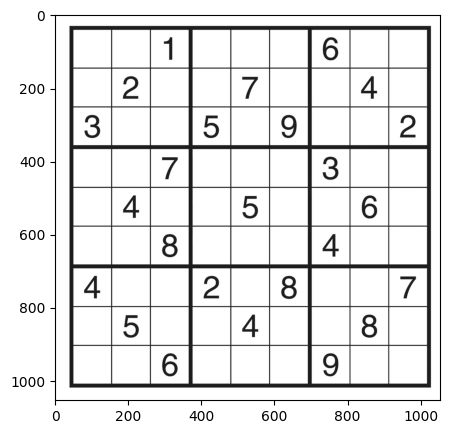

In [5]:
# Here is an example of how to draw a red line
# between (x1, y1) and (x2, y2) on a gray level image, img
# The first step is to create a color image from img.

img = cv2.imread('.\images\Sudoku.PNG', cv2.IMREAD_GRAYSCALE)
imC=np.dstack([img,img,img])   # a gray level image that is saved as a color image
cv2.line(img, (0, 0), (1000, 1000), (255,0,0), 2)
plt.figure(figsize=(5,5))
plt.imshow(imC)
plt.show()

45393


(<matplotlib.image.AxesImage at 0x18290bde910>, Text(0.5, 1.0, 'Edge Image'))

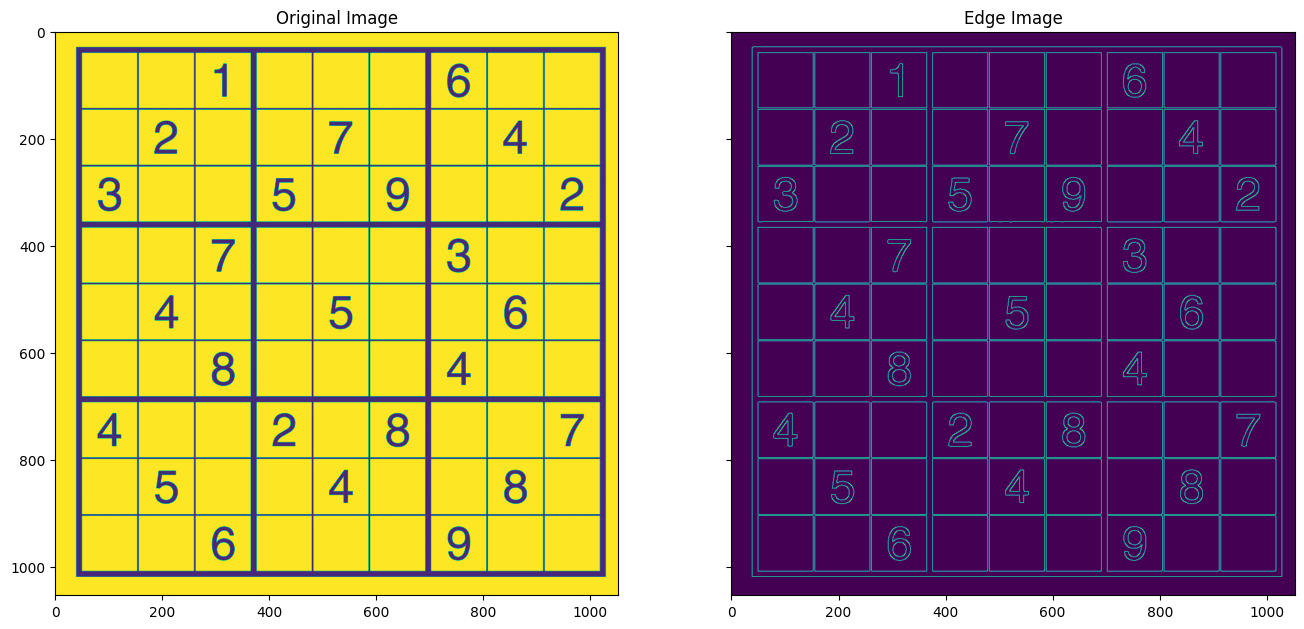

In [6]:
# Here is an example of how to use the CV2 Canny edge detector.
# You can play with the parameters to achieve desired results.
# Note that this implementation does not include smoothing with a Gaussian filter :(


img = cv2.imread('.\images\Sudoku.PNG', cv2.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"

edges = cv2.Canny(img,250,500,5)
print(np.sum(edges > 0))

plt.rcParams['figure.figsize'] = (16.0, 16.0) 
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row')

ax1.imshow(img), ax1.set_title('Original Image')
ax2.imshow(edges), ax2.set_title('Edge Image')


**Apply and answer**

1. Generate a synthetic image to test your Hough Transform algorithm. 
   * Submit the image as well as the results.


2. Apply your algorithm to the following images: Crosswalk, linesOnTheRoadGray, Sudoku. 
   * Choose a set of parameters so the results looks fine.
   * You may need different parameters for each image.
   * Display the results.
   
   
3. **Answer**: How the resolutions of $r$ and $\theta$ affect the results?
   * Display images that demonstarte your answer.
   
   
4. Choose one image and **answer**: how many straight lines did you find with more than 50 points?
   * Display these lines on the image.
   
   
5. Suggest an algorithm to compute the length of the line in the image.
   * Describe the algorithm without implementing it.
   
   
6. Suggest three applications to use the results of straight line detection in an image.



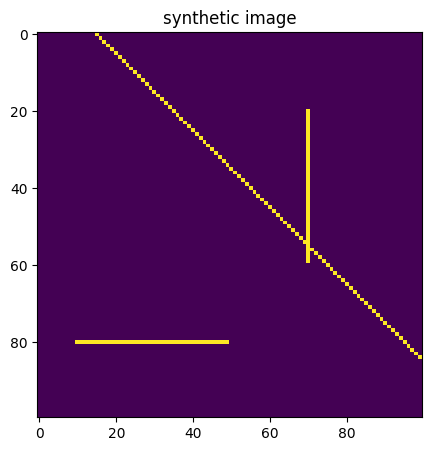

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


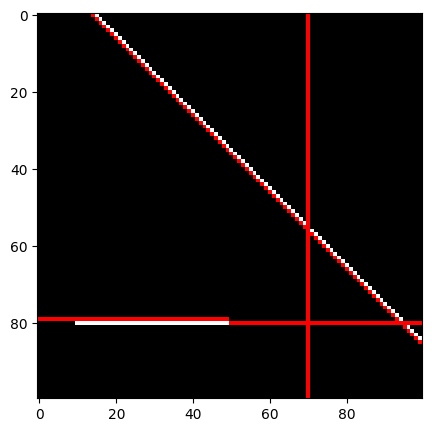

In [7]:
# 1)
def get_edges_indices(edges):
    nonzero_indices = np.nonzero(edges)
    l_points = np.array(list(zip(nonzero_indices[0], nonzero_indices[1])))
    return l_points

def draw_line(m, c):
    x = np.linspace(0, 99, 100)  # array of x values
    y = np.linspace(0, 99, 100)  # array of y values
    x, y = np.meshgrid(x, y)  # Create a grid of points
    z = np.where((y - (m * x + c)) == 0)
    return z
    
def create_synthetic_img():
    lines_image = np.zeros((100, 100))
    lines_image[20:60, 70] = 1

    lines_image[80, 10:50] = 1
    z = draw_line(1, -15)
    lines_image[z] = 1
    return lines_image

img = create_synthetic_img()
l_points = get_edges_indices(img)
res_r = 2
res_orient = 5

h, r_space, theta_space = H_matrix(img, l_points, res_r, res_orient)
list_of_lines = list_lines(h, 35)

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title("synthetic image")
plt.show()

display_lines(img, list_of_lines, r_space, theta_space)

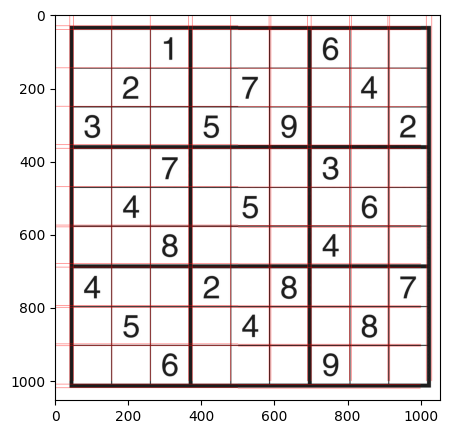

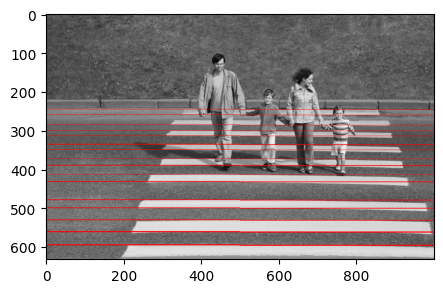

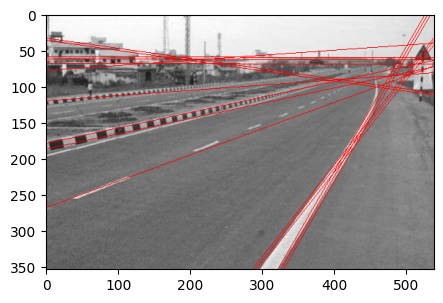

In [8]:
# 2)
lines_sudoku = straight_lines('images/Sudoku.PNG', 5, 30, 500, True)
lines_crosswalk = straight_lines('images/Crosswalk.jpg', 1, 10, 100, True)
lines_road = straight_lines('images/linesOnTheRoadGray.jpg', 3, 8, 100, True)

**3) The affect of the resolutions of $r$ and $\theta$ on the results**:
The resolution of $r$ and $\theta$ affect the amount of points in the $r$ and $\theta$ space. Lesser points (which corresponds to smaller resolution) means that there is a bigger chance for cells to get more votes. In the Sudoku image, which has high contrast, decreasing a bit the $r$ resolution won't affect the result, but for the Crosswalk image, which has a less clear edges (the background behaind the family), decreasing the $resolution$ leads to lots of fake lines

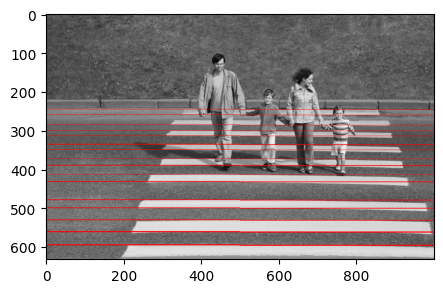

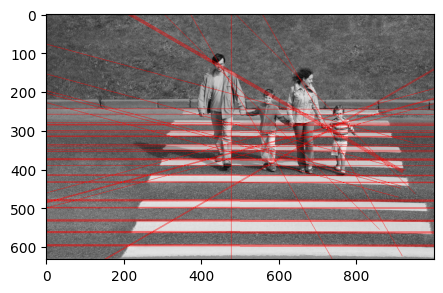

In [9]:
smaller_r = straight_lines('images/Crosswalk.jpg', 1, 15, 100, True)
bigger_r = straight_lines('images/Crosswalk.jpg', 2, 15, 100, True)

As we can see, even a small decreas in the resolution of $r$ leads to bad detection. In the other hand, in other images such as the  linesOnTheRoadGray, decreasing the resolution can helps us by detecting less clearer lines:

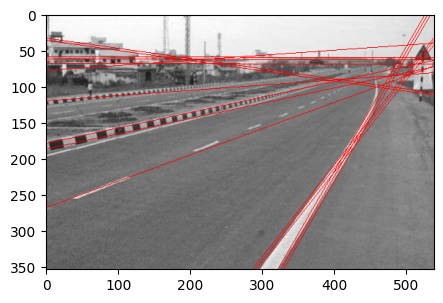

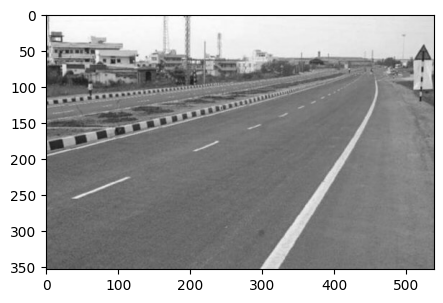

In [10]:
smaller_theta = straight_lines('images/linesOnTheRoadGray.jpg', 3, 8, 100, True)
bigger_theta = straight_lines('images/linesOnTheRoadGray.jpg', 1, 8, 100, True)

resolution can filter several lines that represent the same line but because ansitivity will be appear as well.

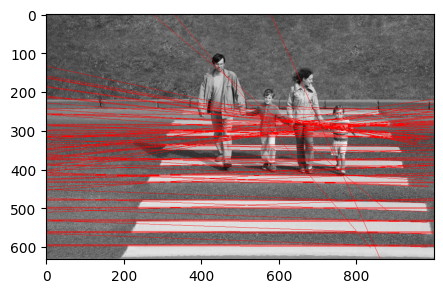

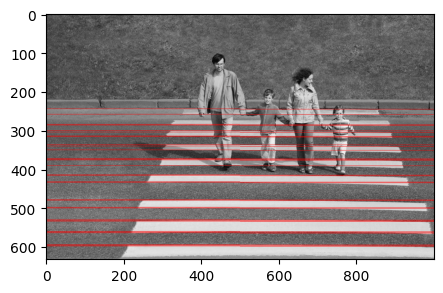

In [11]:
smaller_theta = straight_lines('images/Crosswalk.jpg', 2, 2, 120, True)
bigger_theta = straight_lines('images/Crosswalk.jpg', 2, 45, 120, True)


## <span style="color:blue">Section B: Patch Matching
**In this part you will match intrest points between two images.**
    
    
There are two functions between vectors $v$ and $u$ that you will consider:\
a. Distance: Sum of Square Distance (SSD). That is,  $SSD(u,v)=(u-v)\cdot(u-v)$.\
b. Similarity: Normalized Cross Correlation (NCC). That is,  $NCC(u,v)={u\cdot v \over ||u||||v||}$.


The patch descriptor:
1. A vector with the pixels' grey level.
2. An histogram (30 bins) of the pixels' grey level.
3. A vector with the pixels' strength gradient.
4. An histogram (30 bins) of the pixels' strength of gradient. 


In [16]:
# 1) Compute the corners - taken from previus homework
def create_grid(sig=1):
    x = np.linspace(-sig, sig, 2 * sig + 1)  # array of x values
    y = np.linspace(-sig, sig, 2 * sig + 1)  # array of y values

    return np.meshgrid(x, y)  # Create a grid of points


def crop(img, pad):
    m, n = np.shape(img)

    return img[pad:m - pad, pad:n - pad]  # Removing the given pad from the image


def Gaussian(sig=1):
    x, y = create_grid(sig)

    return (1 / (2 * np.pi * sig ** 2)) * np.exp(-(np.square(x) + np.square(y)) / (2 * sig ** 2))


def gaussian_derivative_x(x, y, sig=1):
    return - (x / (2 * np.pi * sig ** 4)) * np.exp(-(x ** 2 + y ** 2) / (2 * sig ** 2))


def gaussian_derivative_y(x, y, sig=1):
    return - (y / (2 * np.pi * sig ** 4)) * np.exp(-(x ** 2 + y ** 2) / (2 * sig ** 2))


def Deriv_Gauss_xy(sig=1):
    x, y = create_grid(sig)

    div_x = gaussian_derivative_x(x, y, sig)
    div_y = gaussian_derivative_y(x, y, sig)

    return div_x, div_y


def Grad_xy(img, sig=1):
    # 1)
    G_dx, G_dy = Deriv_Gauss_xy(sig)

    Ix_pad = convolve2d(img, G_dx)
    Iy_pad = convolve2d(img, G_dy)

    pad = np.floor(len(G_dx) / 2).astype(int)

    return crop(Ix_pad, pad), crop(Iy_pad, pad)


def d_q(det, trace, k=1):
    return det + k * (trace ** 2)  # Calc the D(q) using the given matrix det and trace


def local_maxima(img, denisty_size):
    m, n = img.shape
    img_copy = img.copy()

    for y in range(0, m, denisty_size):
        for x in range(0, n, denisty_size):
            sub_img = img_copy[y: y + denisty_size, x: x + denisty_size]
            sub_img[sub_img < np.max(sub_img)] = 0

    return img_copy  # A new img with only the maximal value in each window defined by density size


def interesting_points(mat):
    x, y = np.where(mat > 0)
    return np.array(list(zip(y, x)))


def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)

    return 255 * (img - min_val) / (
                max_val - min_val)  # A normalized version of the input image, rescaled to the range [0, 255]


def H_corner(img, sigma_smooth=1, sigma_neighb=1, k=10, th=400, density_size=10, display=0):
    # 2)
    Ix, Iy = Grad_xy(img, sigma_smooth)

    # 3)
    Ix_square = Ix ** 2
    Iy_square = Iy ** 2
    IxIy = Ix * Iy

    # 4)
    G = Gaussian(sigma_neighb)
    C11 = crop(convolve2d(Ix_square, G), sigma_neighb)
    C12 = C21 = crop(convolve2d(IxIy, G), sigma_neighb)
    C22 = crop(convolve2d(Iy_square, G), sigma_neighb)

    # 5)
    det = C11 * C22 - C12 * C21
    trace = C11 + C22

    D = d_q(det, trace, k)

    # 6)
    D_th = D.copy()
    D_th[D_th < th] = 0

    # 7)
    D_maxima = local_maxima(D_th, density_size)

    detected_corners = interesting_points(D_maxima)

    if display == 1:
        plot_graph(img, title="The original image")
        plot_graphs(img1=Ix, img1_title="The derivatives of Ix", img2=Iy, img2_title="The derivatives of Iy")
        plot_graphs(img1=normalize(D), img1_title="normalized D", img2=normalize(D_th) > 0,
                    img2_title="normelized D_th")
        plot_overlay(img, "detected_corners", detected_corners)

    return D_maxima


In [22]:
#Implement the following functions:

# Input: two vectors
# Output distance (scalar) between two patches

def SSD(patch_descr_1, patch_descr_2):
    return np.diag((patch_descr_1 - patch_descr_2) @ (patch_descr_1 - patch_descr_2).T)

# Input: two vectors
# Output normalized cross correlation  (scalar) between two patches

def NCC(patch_descr_1, patch_descr_2):
    return np.diag(patch_descr_1 @ patch_descr_2.T) / (
                np.linalg.norm(np.diag(patch_descr_1)) * np.linalg.norm(np.diag(patch_descr_2)))

# Output a descriptor vector 
# im is an image, p is a pixel, size is the patch size.
# You can use the histogram function of open cv or numpy

def patch_from_im(im, p, size):
    im_padded = np.pad(im, pad_width=size // 2, mode='constant', constant_values=0)
    p_pad = p + size // 2
    patch = im_padded[p_pad[0] - size // 2:p_pad[0] + size // 2 + 1,
            p_pad[1] - size // 2:p_pad[1] + size // 2 + 1].flatten()
    return patch

def hist_patch_im(im, p, size):
    histogram = cv2.calcHist([patch_from_im(im, p, size)], [0], None, [30], [0, 255]).flatten()
    return histogram / np.linalg.norm(histogram)

def gradient(im, p, size):
    Ix, Iy = Grad_xy(im)
    I_xy_strength = np.sqrt(Ix ** 2 + Iy ** 2)
    I_xy_strength_pad = np.pad(I_xy_strength, pad_width=size // 2, mode='constant', constant_values=0)
    p_pad = p + size // 2
    grad = I_xy_strength_pad[p_pad[0] - size // 2 - 1:p_pad[0] + size // 2,
           p_pad[1] - size // 2:p_pad[1] + size // 2 + 1].flatten()
    return np.round(grad).astype(np.uint8)

def hist_gradient(im, p, size):
    grad_histogram = cv2.calcHist([gradient(im, p, size)], [0], None, [30], [0, 255]).flatten()
    return grad_histogram / np.linalg.norm(grad_histogram)

def gradient_opt(I_xy_strength_pad, p, size):
    p_pad = p + size // 2
    grad = I_xy_strength_pad[p_pad[0] - size // 2 - 1:p_pad[0] + size // 2,
           p_pad[1] - size // 2:p_pad[1] + size // 2 + 1].flatten()
    return np.round(grad).astype(np.uint8)


def hist_gradient_opt(I_xy_strength_pad, p, size):
    grad_histogram = cv2.calcHist([gradient_opt(I_xy_strength_pad, p, size)], [0], None, [30], [0, 255]).flatten()
    return grad_histogram / np.linalg.norm(grad_histogram)

def get_top_n_points(matrix, n):
    # Create an array of tuples [value, x_index, y_index]
    points = [(matrix[i, j], i, j) for i in range(matrix.shape[0]) for j in range(matrix.shape[1]) if
              0 < i < matrix.shape[0] - 1 and 0 < j < matrix.shape[1] - 1]

    # Sort the array based on the values in descending order
    sorted_points = sorted(points, key=lambda x: x[0], reverse=True)

    # Get the top n points
    top_n_points = sorted_points[:n]

    return top_n_points


def get_corners(n, image1, image2):
    h_points_matrix1 = H_corner(image1, sigma_smooth=1, sigma_neighb=1, k=5, th=100, density_size=5, display=0)
    h_points_matrix2 = H_corner(image2, sigma_smooth=1, sigma_neighb=1, k=5, th=100, density_size=5, display=0)
    corners1 = get_top_n_points(h_points_matrix1, n)
    corners2 = get_top_n_points(h_points_matrix2, n)
    corners1 = np.array([(p[1], p[2]) for p in corners1])
    corners2 = np.array([(p[1], p[2]) for p in corners2])
    return corners1, corners2

def match_patterns(image1, image2, patch_size=50, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=200,
                   y_th=None, display=0):
    n, m = image1.shape
    images = cv2.hconcat([image1, image2])
    imC = np.dstack([images, images, images])
    corners1, corners2 = get_corners(amount_of_edges, image1, image2)
    matching_points = []

    for p in corners1:
        # get the corners that have approximately the same y value as the current corner
        relevant_im2_corners = corners2[p[0] - y_th <= corners2[:, 0]] if y_th is not None else corners2
        relevant_im2_corners = relevant_im2_corners[relevant_im2_corners[:, 0] <= p[0] + y_th] if y_th is not None else corners2
        if relevant_im2_corners.size == 0:
            continue
        # get the patch of the current corner and duplicate it to the amount of edges
        patches_1 = np.tile(patch_descriptor(image1, p, patch_size), (len(relevant_im2_corners), 1))
        # get the patches of the second image
        patches_2 = np.array([patch_descriptor(image2, q, patch_size) for q in relevant_im2_corners])
        # calculate the metric between the current patch and all the patches of the second image
        metric_result = np.array(metric(patches_1, patches_2))
        # get the index of the minimum/maximum value for the second image up to a threshold
        index = np.argmin(metric_result) if metric == SSD else np.argmax(metric_result)
        q = relevant_im2_corners[index]
        cv2.line(imC, (p[1], p[0]), (q[1] + m, q[0]), (255, 0, 0), 1)

        matching_points.append((p, q))

    if display:
        plt.imshow(imC)
        plt.show()

    return matching_points


def match_patterns_with_grad(image1, image2, patch_size=50, metric=SSD, patch_descriptor=hist_gradient_opt, amount_of_edges=200,
                   y_th=None, display=0):
    n, m = image1.shape
    images = cv2.hconcat([image1, image2])
    imC = np.dstack([images, images, images])
    corners1, corners2 = get_corners(amount_of_edges, image1, image2)
    Ix_1, Iy_1 = Grad_xy(image1)
    I_xy_strength_1 = np.sqrt(Ix_1 ** 2 + Iy_1 ** 2)
    I_xy_strength_pad_1 = np.pad(I_xy_strength_1, pad_width=patch_size // 2, mode='constant', constant_values=0)

    Ix_2, Iy_2 = Grad_xy(image2)
    I_xy_strength_2 = np.sqrt(Ix_2 ** 2 + Iy_2 ** 2)
    I_xy_strength_pad_2 = np.pad(I_xy_strength_2, pad_width=patch_size // 2, mode='constant', constant_values=0)

    matching_points = []
    mismatching_points = []

    for i, p in enumerate(corners1):
        # get the corners that have approximately the same y value as the current corner
        relevant_im2_corners = corners2[p[0] - y_th <= corners2[:, 0]] if y_th is not None else corners2
        relevant_im2_corners = relevant_im2_corners[
            relevant_im2_corners[:, 0] <= p[0] + y_th] if y_th is not None else corners2
        if relevant_im2_corners.size == 0:
            continue
        # get the patch of the current corner and duplicate it to the amount of edges
        patches_1 = np.tile(patch_descriptor(I_xy_strength_pad_1, p, patch_size), (len(relevant_im2_corners), 1))
        # get the patches of the second image
        patches_2 = np.array([patch_descriptor(I_xy_strength_pad_2, q, patch_size) for q in relevant_im2_corners])
        # calculate the metric between the current patch and all the patches of the second image
        metric_result = np.array(metric(patches_1, patches_2))
        # get the index of the minimum/maximum value for the second image up to a threshold
        first_index = np.argmin(metric_result) if metric == SSD else np.argmax(metric_result)
        first_match = metric_result[first_index]
        metric_result[first_index] = np.iinfo(np.int32).max if metric == SSD else -np.iinfo(np.int32).max
        second_index = np.argmin(metric_result) if metric == SSD else np.argmax(metric_result)
        second_match = metric_result[second_index]
        q = relevant_im2_corners[first_index]

        # check if the ratio between the best and the second best match is greater than 0.8
        if first_match / second_match > 0.8:
            mismatching_points.append((p, q))
            continue

        matching_points.append((p, q))

    if display:
        plt.imshow(imC)
        plt.show()

    return matching_points, mismatching_points

**Apply and answer**


1. Compute the corners in a pair of images (e.g., view0.tif and view6.tif).


2. Choose up to 2000 of the strongest corners (you can use fewer) and find a matching between the corners in the pair of images.
    * Choose a fixed scale and use it to define a patch around each corner.
    * To display the matching, use the function cv2.hconcat([im1, im2]), which concatenates two images horizontally, and then draw lines as described in the previous section.


3. Use up to 4000 of the strongest corners (you can use fewer) in each image and use the matching only between corners that have approximately the same y-coordinate (up to a threshold).


4. Study the ratio for matching between the best and the second best match. 
   * You can use NCC or SSD on the desriptor of your choice.
   * You can use without (2) or with (3) the $y$-coordinate constraint.
   * **Present** examples that demonstrate the effectiveness of using the ratio.


5. Study the differences between the different descriptors and also the use of SSD or NCC. 
   * **Present**  examples that demonstrate your findings.


6. Identify incorrect pairs of matched points.\
   **Mark and display** for cases (2), (3), and (4) a pair of incorrectly matched points.\
   **Answer**\
   a. In which of the 3 cases are there more incorrect matches?\
   b. What may be the reason for the incorrect matches?


7. In which regions of the scene were most of the reliable matches found?



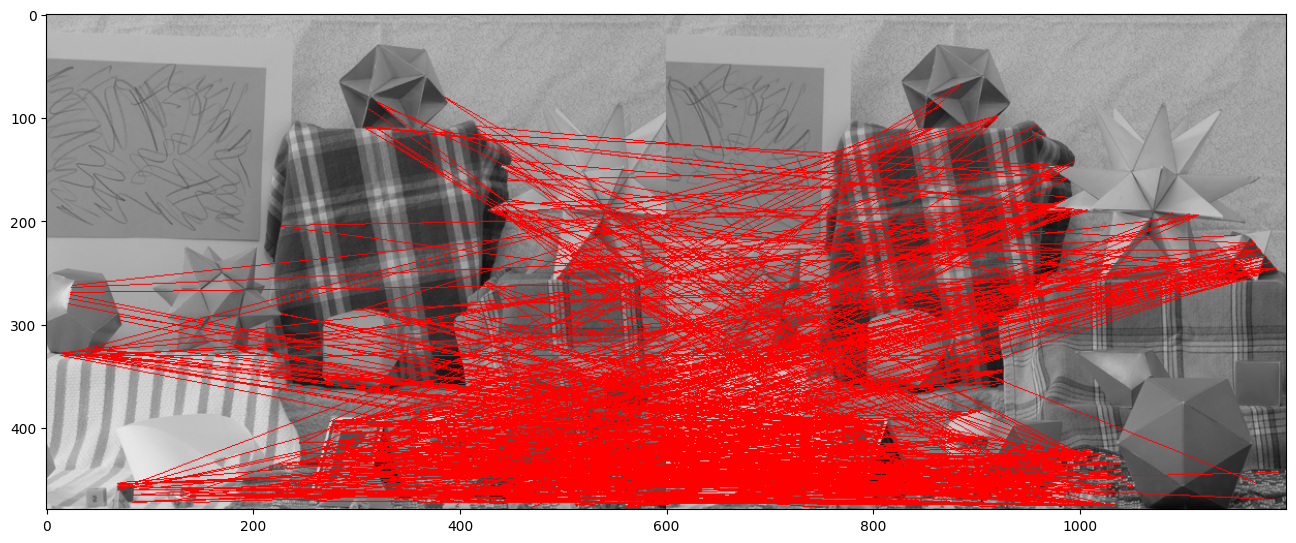

In [14]:
# 1 + 2) 
img1 = cv2.imread('images/view0.tif', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/view6.tif', cv2.IMREAD_GRAYSCALE)

res2 = match_patterns(img1, img2, patch_size=51, metric=SSD, patch_descriptor=patch_from_im, amount_of_edges=500, display=1)

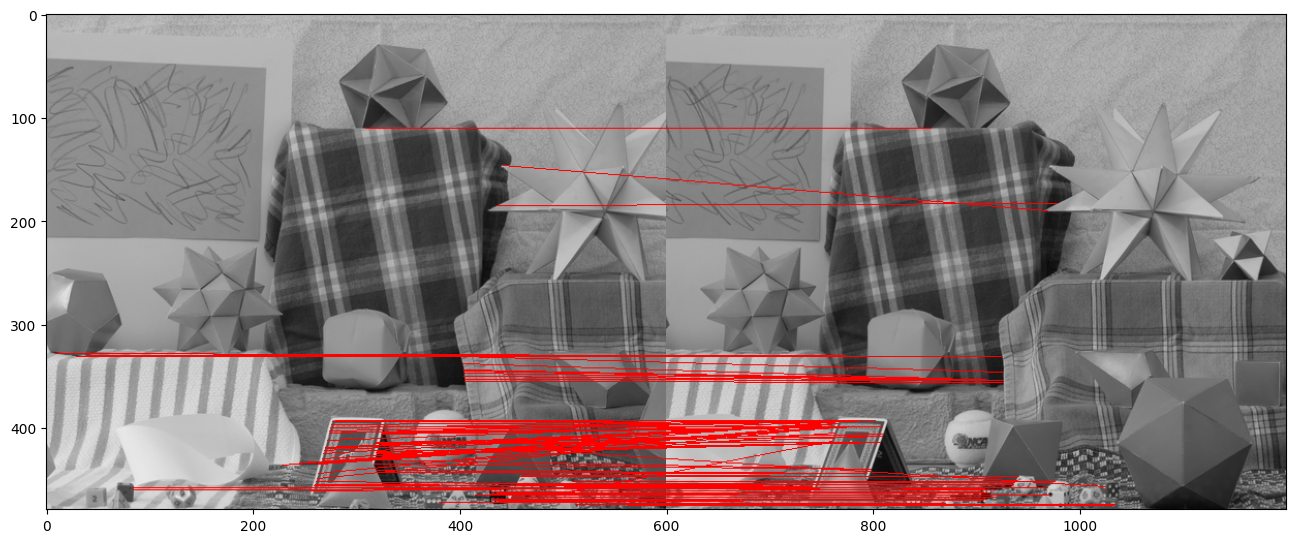

In [15]:
# 3)
res3 = match_patterns(img1, img2, patch_size=21, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=100, y_th=50, display=1)

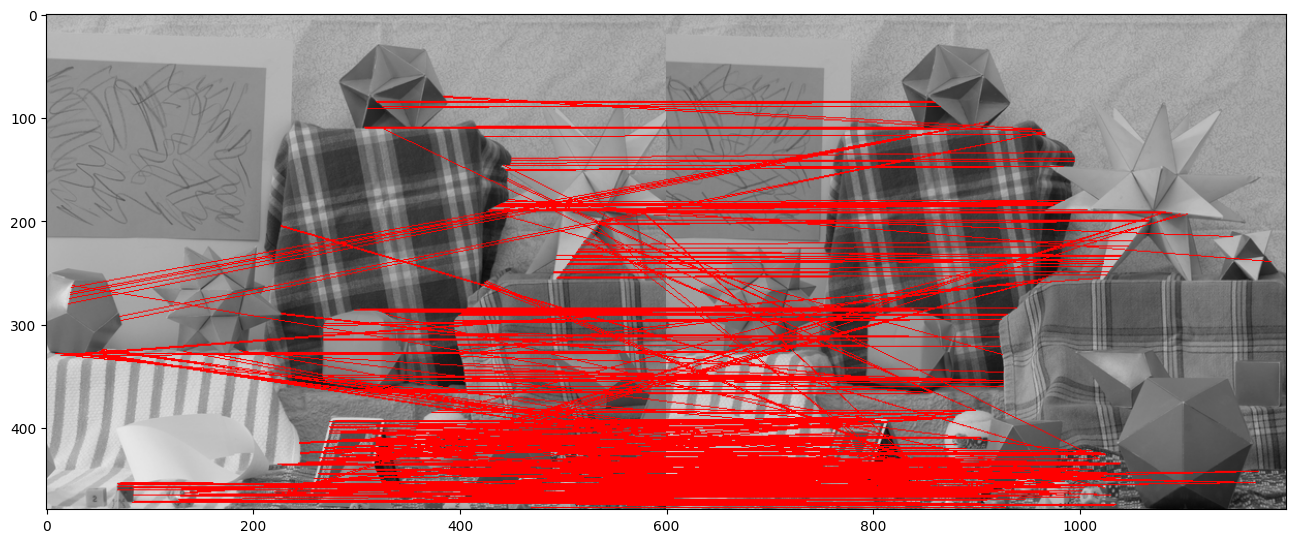

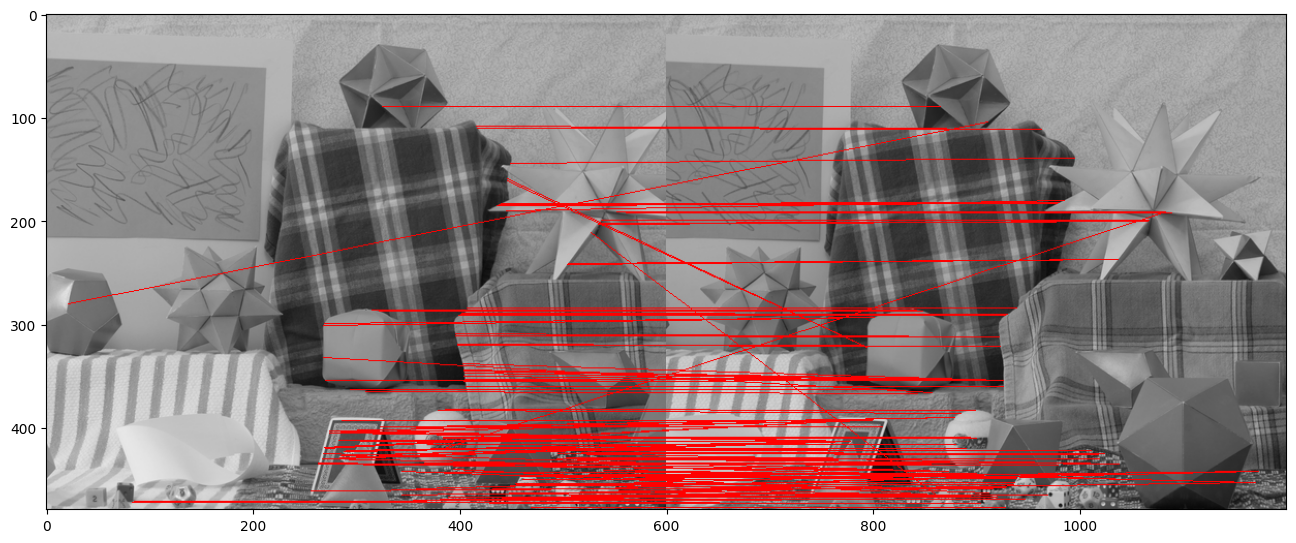

([(array([463, 501]), array([465, 369])),
  (array([469, 441]), array([469, 310])),
  (array([435, 263]), array([442, 273])),
  (array([353, 405]), array([354, 326])),
  (array([344, 404]), array([354, 326])),
  (array([345, 404]), array([354, 326])),
  (array([338, 403]), array([354, 326])),
  (array([434, 263]), array([442, 273])),
  (array([403, 274]), array([393, 199])),
  (array([347, 405]), array([354, 326])),
  (array([393, 286]), array([393, 174])),
  (array([399, 326]), array([399, 209])),
  (array([454, 455]), array([453, 337])),
  (array([455, 455]), array([455, 336])),
  (array([419, 270]), array([394, 164])),
  (array([393, 304]), array([393, 174])),
  (array([393, 305]), array([393, 174])),
  (array([393, 293]), array([393, 174])),
  (array([399, 323]), array([399, 209])),
  (array([435, 265]), array([442, 273])),
  (array([420, 270]), array([394, 164])),
  (array([459, 432]), array([459, 316])),
  (array([447, 459]), array([449, 339])),
  (array([425, 268]), array([442, 

In [20]:
# 4)
def match_patterns_with_ratio(image1, image2, patch_size=50, metric=SSD, patch_descriptor=hist_patch_im,
                              amount_of_edges=200,
                              y_th=None, display=0):
    n, m = image1.shape
    images = cv2.hconcat([image1, image2])
    imC = np.dstack([images, images, images])
    corners1, corners2 = get_corners(amount_of_edges, image1, image2)
    matching_points = []
    mismatching_points = []

    for p in corners1:
        # get the corners that have approximately the same y value as the current corner
        relevant_im2_corners = corners2[p[0] - y_th <= corners2[:, 0]] if y_th is not None else corners2
        relevant_im2_corners = relevant_im2_corners[
            relevant_im2_corners[:, 0] <= p[0] + y_th] if y_th is not None else corners2
        if relevant_im2_corners.size == 0:
            continue
        # get the patch of the current corner and duplicate it to the amount of edges
        patches_1 = np.tile(patch_descriptor(image1, p, patch_size), (len(relevant_im2_corners), 1))
        # get the patches of the second image
        patches_2 = np.array([patch_descriptor(image2, q, patch_size) for q in relevant_im2_corners])
        # calculate the metric between the current patch and all the patches of the second image
        metric_result = np.array(metric(patches_1, patches_2))
        # get the index of the minimum/maximum value for the second image up to a threshold
        first_index = np.argmin(metric_result) if metric == SSD else np.argmax(metric_result)
        first_match = metric_result[first_index]
        metric_result[first_index] = 99999999 if metric == SSD else -99999999
        second_index = np.argmin(metric_result) if metric == SSD else np.argmax(metric_result)
        second_match = metric_result[second_index]
        q = relevant_im2_corners[first_index]

        # check if the ratio between the best and the second-best match is greater than 0.8
        if (metric == SSD and (second_match == 0 or first_match / second_match > 0.8)) or (
                metric == NCC and (second_match == 0 or first_match / second_match < 1.028)):
            mismatching_points.append((p, q))
            continue

        q = relevant_im2_corners[first_index]
        cv2.line(imC, (p[1], p[0]), (q[1] + m, q[0]), (255, 0, 0), 1)

        matching_points.append((p, q))

    if display:
        plt.imshow(imC)
        plt.show()

    return matching_points, mismatching_points


match_patterns(img1, img2, patch_size=21, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=500, y_th=None,
               display=1)

match_patterns_with_ratio(img1, img2, patch_size=21, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=500,
                          y_th=None,
                          display=1)

As indicated above, we are eliminating points with a high resemblance (a ratio of 0.8) between the first and second-best match, which are evidently not corresponding points because of their disparity in the y-coordinate. Additionally, even without a y-coordinate threshold, we achieve effective filtering.

In [ ]:
# 5)
_, _ = match_patterns_with_grad(img1, img2, patch_size=31, metric=SSD, patch_descriptor=hist_gradient_opt, amount_of_edges=400, y_th=None, display=1)
_, _ = match_patterns_with_grad(img1, img2, patch_size=31, metric=NCC, patch_descriptor=hist_gradient_opt, amount_of_edges=400, y_th=None, display=1)

_, _ = match_patterns_with_grad(img1, img2, patch_size=31, metric=SSD, patch_descriptor=gradient_opt, amount_of_edges=400, y_th=None, display=1)
_, _ = match_patterns_with_grad(img1, img2, patch_size=31, metric=NCC, patch_descriptor=gradient_opt, amount_of_edges=400, y_th=None, display=1)

_, _ = match_patterns(img1, img2, patch_size=31, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=400, y_th=None, display=1)
_, _ = match_patterns(img1, img2, patch_size=31, metric=NCC, patch_descriptor=hist_patch_im, amount_of_edges=400, y_th=None, display=1)

_, _ = match_patterns(img1, img2, patch_size=31, metric=SSD, patch_descriptor=patch_from_im, amount_of_edges=400, y_th=None, display=1)
_, _ = match_patterns(img1, img2, patch_size=31, metric=NCC, patch_descriptor=patch_from_im, amount_of_edges=400, y_th=None, display=1)

Conclusions we can get from the examples above:
- SSD and NCC have given the same results
- Gradient patch descriptors are less accurate than the regular patch descriptor
- histograms causing NCC and SSD to give the same results (eliminating the dependency in intensity's position)
- histograms are more accurate than the patch descriptors with no histogram
- without descriptors, both the gradient patch and the regular patch are less accurate.

C:\Users\almogze\AppData\Local\Temp\ipykernel_22572\4092252683.py:28: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 99999999 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  metric_result[first_index] = 99999999 if metric == SSD else -99999999
C:\Users\almogze\AppData\Local\Temp\ipykernel_22572\3020801432.py:151: RuntimeWarning: invalid value encountered in scalar divide
  if first_match / second_match > 0.8:


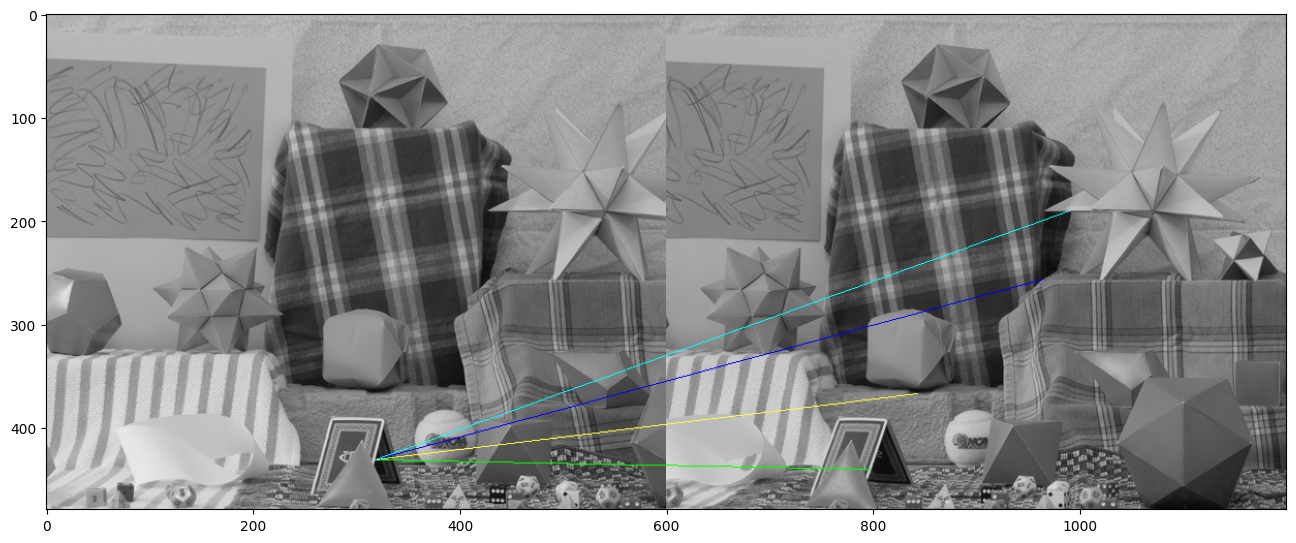

Case 2 number of mismatch points: 343. SSD + no y-coordinate constraint + histogram descriptor
Case 3 number of mismatch points: 328. SSD + y-coordinate constraint of 10 pixles + histogram descriptor
Case 4 SSD number of mismatch points: 363. SSD + no y-coordinate constraint + Patch descriptor
Case 4 NCC number of mismatch points: 445. NCC + no y-coordinate constraint + histogram descriptor
Case 4 gradient histogram number of mismatch points: 175. SSD + no y-coordinate constraint + gradient histogram descriptor


In [23]:
# 6)

# Mark and display for cases (2)
_, mismatch2 = match_patterns_with_ratio(img1, img2, patch_size=21, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=500, y_th=None, display=0)
# Mark and display for cases (3)
_, mismatch3 = match_patterns_with_ratio(img1, img2, patch_size=21, metric=SSD, patch_descriptor=hist_patch_im, amount_of_edges=500, y_th=10, display=0)
    # Mark and display for cases (4)
_, mismatch4_1 = match_patterns_with_ratio(img1, img2, patch_size=21, metric=SSD, patch_descriptor=patch_from_im, amount_of_edges=500, y_th=None, display=0)
_, mismatch4_2 = match_patterns_with_ratio(img1, img2, patch_size=21, metric=NCC, patch_descriptor=hist_patch_im, amount_of_edges=500, y_th=None, display=0)
_, mismatch4_3 = match_patterns_with_grad(img1, img2, patch_size=21, metric=SSD, patch_descriptor=hist_gradient_opt, amount_of_edges=500, y_th=None, display=0)

n, m = img1.shape
images = cv2.hconcat([img1, img2])
image = np.dstack([images, images, images])

p2, q2 = mismatch2[0]
p3, q3 = mismatch3[0]
p4_1, q4_1 = mismatch4_1[0]
p4_2, q4_2 = mismatch4_2[0]
p4_3, q4_3 = mismatch4_3[0]

cv2.line(image, (p2[1], p2[0]), (q2[1] + m, q2[0]), (255, 0, 0), 1)
cv2.line(image, (p3[1], p3[0]), (q3[1] + m, q3[0]), (0, 255, 0), 1)
cv2.line(image, (p4_1[1], p4_1[0]), (q4_1[1] + m, q4_1[0]), (255, 255, 55), 1)
cv2.line(image, (p4_2[1], p4_2[0]), (q4_2[1] + m, q4_2[0]), (0, 0, 255), 1)
cv2.line(image, (p4_3[1], p4_3[0]), (q4_3[1] + m, q4_3[0]), (0, 255, 255), 1)

plt.imshow(image)
plt.show()

print(f'Case 2 number of mismatch points: {len(mismatch2)}. SSD + no y-coordinate constraint + histogram descriptor')
print(f'Case 3 number of mismatch points: {len(mismatch3)}. SSD + y-coordinate constraint of 10 pixles + histogram descriptor')
print(f'Case 4 SSD number of mismatch points: {len(mismatch4_1)}. SSD + no y-coordinate constraint + Patch descriptor')
print(f'Case 4 NCC number of mismatch points: {len(mismatch4_2)}. NCC + no y-coordinate constraint + histogram descriptor')
print(f'Case 4 gradient histogram number of mismatch points: {len(mismatch4_3)}. SSD + no y-coordinate constraint + gradient histogram descriptor')

6. a) The worst case is 4. Using patch descriptors without histograms.

   b)  Without organizing the intensity there are more chances of getting a false positive match.

7) The most reliable region was the lower middle part, which has lots of small parts with a high distribution of interesting points without similarity to other places. Unlike the upper middle region which has a square pattern that is repetitive to a lot of other regions.

**Implementation details**

You can compute the NCC or SSD patch by patch. This will probably takes longer than using matrix multiplications of numpy.

Using matrices:
1. Generate a 1D vector from each descriptor.


2. Generate a matrix $M_1$:  rows  are  the descriptors of img1.


3. Generate a matrix $M_2$:  columns  are  the descriptors of img2.


4. $M=np.matmul(M_1,M_2)$\
   * what is the value in $M(i,j)$?


5. Think of how to normalize the set of patches, if you need.
   * You can consider using the function np.diag(np.diag(matrix)) as part of your solution.
    
    

## Part C ## 

In this part you will compute the 3D structure from a pair of rectified images.


**The input:**\
    **a.** A pair of two rectified images, $im1$ and $im2$ (*view1.png and view5.png*).\
    **b.** A window size $(s_x,s_y$).\
    **c.** Disparity range $(d_{min},d_{max})$ (see below).

**The output:**\
**a.** A matrix, $D$ with the disparity map for the left image.\
**b.** Three matrices X, Y, Z with the x, y, z-coordinates of each pixel in the left image. Assign zero for pixels for which the disparity was not computed.

Note: all matrices $im1, im2, D, X, Y, Z$ have the same dimensions.

**Instructions:**
1. Read the two images view1.png and view5.png, and apply the functions to this pair of images.

   
2. Write a function that receives two rectified images, and compute dense matching along lines with the same $y-$coordinate.
    * You can use any of the descriptors from Part B. The patch size should be given as a parameter.
    * Use NCC for the similarity measure.
    * You can assume that you are given the range of disparities, $d_{min},d_{max}$ as an input. \
      For example, if  $(d_{min},d_{max})=(20,120)$ it follows that the corresponding point of  $(x,y)$ in the left image, is in the range $(x-120:x-20,y)$ in the right image.
    * Consider matching with and without order preseving. 
    * List all parameters you use for your function.
    * Hints on efficient implementation is given below.
    
        
3. Write a function that computes the disparity based on (2).  
    * **Display** the disparity $D$ map as an image
   
  
4. Compute the depth map using the disparity.
    * Assume that scaled focal lengths ($f$ in the presentation) are $α_x=α_y=1$.
    * The distance between the cameras is 160mm.
    * Add to your disparity depth map the value 100, since images were cropped. 
    * Display the disparity as an image. 
   

4. Compute the matrices X,Y,Z
    * Present the object given by X,Y,Z using a 3D plot.


**Implementation**\
You can implement the computation of the similarity and the disparity directly by an exhaustive search. You can also use the idea from Part B. A more efficeint and elegant way is described below. You are welcome to try, but you do not have to.


General idea for the **vectorized solution** (you will need to fill in the gaps):
* Let $w$ and $h$ we the width and the height of the image respectively.
* First assume that the patch size is $1\times s_y$.
* Given two $1\times w$ rows, $r_1$ and $r_2$ which are corresponding rows of the two images. Compute the $w\times w$ matrix $R12=r_1^T r_2$. The values $R12(i,j)$ consists of the product of two pixels $r_1(i)\cdot r_2(j)$.
* Convolve $R12$ with the $s_y\times s_y$ identity matrix, $I_{s_y}$ : $Corr=I_{s_y}*R12$. The value $Corr(i,j)$ is the correlation of the $s_y$ 1D neighborhood of $r_1(i)$ and  $r_2(j)$.
* Think about how to normalize this correlation using the same idea. Hint, use the computation of $I_{s_y}*(r_1^Tr_1)$ and $I_{s_y}*(r_2^Tr_2)$.
* For a general patch size, $s_x\times s_y$, define $R$ to be 3D matrix of size $h\times w\times s_x$ and use 3D mask for the convolution.
* Up to here, we considered each row seperately, hence we need to loop over all rows of the images. There is a way to do it without looping, but not in this assignemnt :)


In [ ]:
img1 = cv2.imread('images/view1.tif', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('images/view5.tif', cv2.IMREAD_GRAYSCALE)

In [ ]:
matching_points = match_patterns(img1, img2, patch_size=51, metric=SSD, patch_descriptor=hist_patch_im,
                                       amount_of_edges=1000, y_th=1, display=display)

In [30]:
def get_dense_matching(im1, im2, d_range=(20, 120), display=0):
    # matching_points = b.match_patterns(im1, im2, patch_size=41, metric=b.SSD, patch_descriptor=b.hist_patch_im,
    #                                    amount_of_edges=10000, y_th=1, display=display)

    # filter matching_points by d_range
    filtered_matching_points = []
    for (p, q) in matching_points:
        if d_range[0] <= p[1] - q[1] <= d_range[1]:
            filtered_matching_points.append((p, q))

    return filtered_matching_points

def compute_disparity(im1, im2, d_range=(20, 120), display=0):
    matching_points = get_dense_matching(im1, im2, d_range, display)
    disparity = np.zeros(im1.shape)
    for (p, q) in matching_points:
        disparity[p[0], p[1]] = p[1] - q[1]

    if display:
        plt.imshow(disparity, cmap='gray')
        plt.show()

    return disparity

def compute_depth_map(im1, im2, d_range=(20, 120), display=0):
    disparity = compute_disparity(im1, im2, d_range, display)

    positive = disparity > 0
    depth_map = np.zeros(im1.shape)
    depth_map[positive] = 160 / (disparity[positive] + 100)

    if display:
        plt.imshow(depth_map, cmap='gray')
        plt.colorbar()
        plt.show()

    return depth_map

def compute_3D_points(im1, im2, d_range=(20, 120), display=0):
    z = compute_depth_map(im1, im2, d_range, display)
    x, y = np.meshgrid(np.arange(im1.shape[1]), np.arange(im1.shape[0]))
    # delete all the points with depth 0
    x = x[z > 0]
    y = y[z > 0]
    z = z[z > 0]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=x, ys=z, zs=y, s=1.5)
    plt.show()

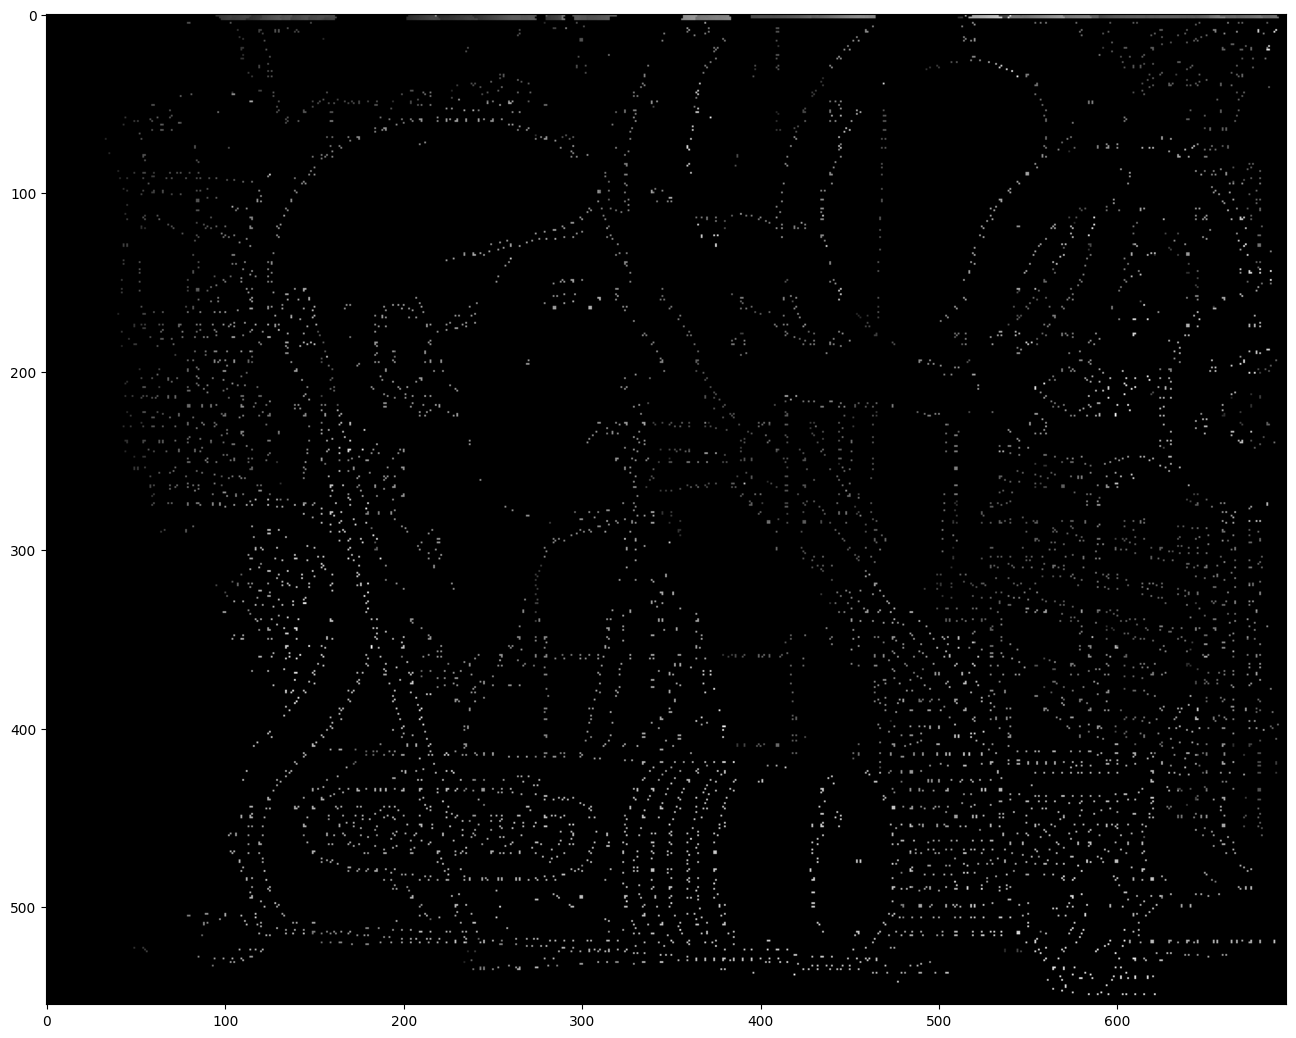

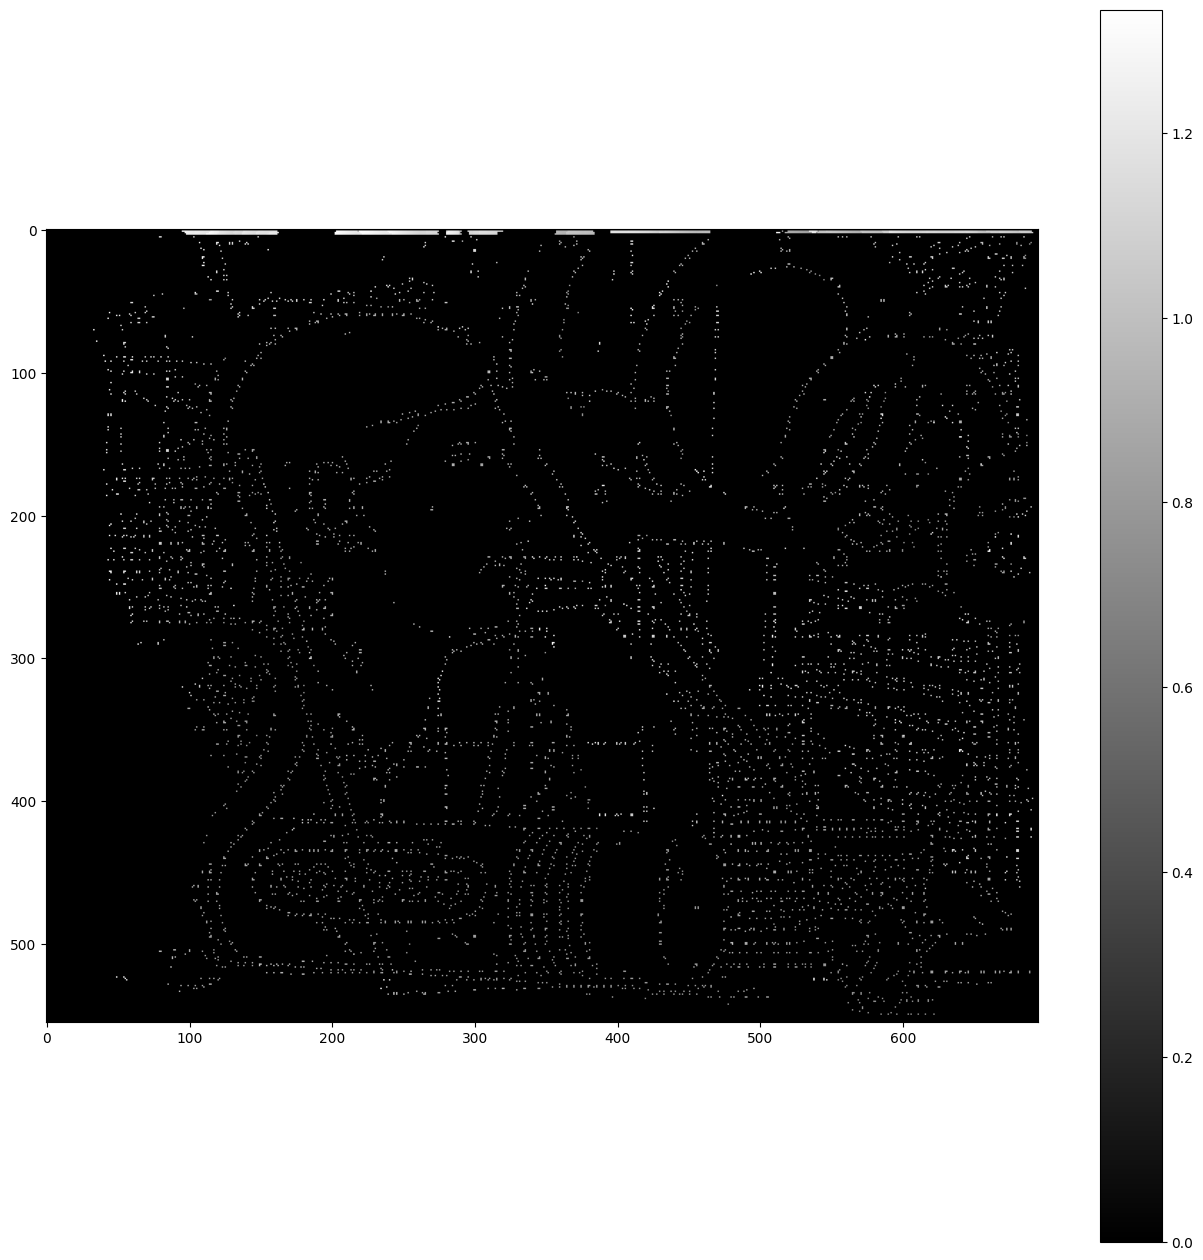

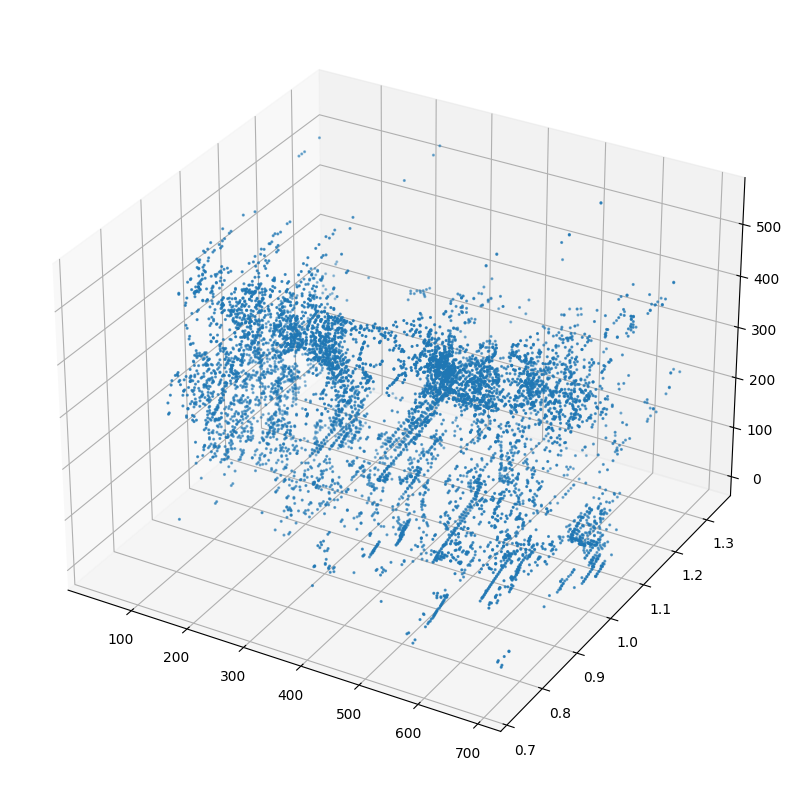

In [31]:
compute_3D_points(img1, img2, d_range=(20, 120), display=1)